In [1]:
from winners_only import *
from log import *
from historical import *
import pandas as pd
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv("data/updated_data.csv")

In [4]:
X_train, y_train, test_2019,master = historical_cleaning(df)

In [37]:
cols = list(X_train.columns)

In [4]:
# n_estimators = [100,250,500,750,1000,1500,2000,2500]
# max_depth = [2,4,6,8]
# learning_rate = [0.1,0.3,0.5]
# subsample = [0.25,0.5,0.75]



In [38]:
n_estimators = [100]
max_depth = [2]
learning_rate = [0.1]
subsample = [0.5]


In [39]:
param_info = []
acc_info = []

In [40]:
for n in n_estimators:
    for d in max_depth:
        for lr in learning_rate:
            for sub in subsample:
                XGBR = xgb.XGBClassifier(colsample_bytree=0.4, gamma=0, learning_rate=lr, max_depth=d, 
                min_child_weight=1.5, n_estimators=n, reg_alpha=0.75, reg_lambda=0.45, subsample=sub, seed=42)
                #
                XGBR.fit(X_train,y_train)
                param_info.append([n,d,lr,sub])
                prediction = pd.DataFrame(test_2019["Fighter"])
                test_2019_clean = test_2019.drop(columns = ["Fighter","Result"])
                prediction["Win Probability"] = XGBR.predict_proba(test_2019_clean)[:,1]
                prediction = prediction.set_index("Fighter")
                p2019 = prediction.to_dict()["Win Probability"]
                fighter_data = list(p2019.keys())
                check = df
                check["year"] = check["date"].apply(lambda x: x[:-6])
                check = check[check["year"]=="2019"]
                check = check[~check["B_avg_BODY_att"].isnull()]
                check = check[check["R_fighter"].apply(lambda x: x in fighter_data)]
                check = check[check["B_fighter"].apply(lambda x: x in fighter_data)]
                comparison = check[["R_fighter","B_fighter","Winner"]]
                comparison["R_Fighter_Proba"] = comparison["R_fighter"].apply(lambda x: p2019[x] if x in list(p2019.keys()) else 0)
                comparison["B_Fighter_Proba"] = comparison["B_fighter"].apply(lambda x: p2019[x] if x in list(p2019.keys()) else 0)
                comparison["Proba Results"] = comparison.apply(lambda x: "Red" if x["R_Fighter_Proba"] >= x["B_Fighter_Proba"] else "Blue",axis=1)
                comparison["Correct"] = comparison["Winner"] == comparison["Proba Results"]
                a = list(comparison["Correct"])
                acc = np.mean(a)
                acc_info.append(acc)
                print([n,d,lr,sub],acc)

[100, 2, 0.1, 0.5] 0.6011904761904762


In [39]:
impfeat =  sorted(zip(XGBR.feature_importances_.round(4),cols),reverse=True)[:11]

In [40]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, '')

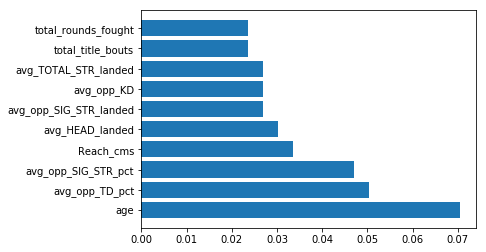

In [42]:
title, value = [],[]
for each in impfeat:
    title.append(each[1])
    value.append(each[0])

title.pop(3)
value.pop(3)
plt.barh(title,value)
plt.title("")

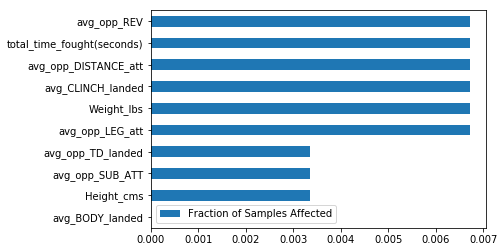

In [22]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : XGBR.feature_importances_},
                           index=cols)
new = feat_scores.sort_values(by='Fraction of Samples Affected')
new.head(10).plot(kind='barh',);

In [23]:
new.head()

,Fraction of Samples Affected
avg_BODY_landed,0.000000
Height_cms,0.003356
avg_opp_SUB_ATT,0.003356
avg_opp_TD_landed,0.003356
avg_opp_LEG_att,0.006711


In [19]:

grid_results = sorted(zip(acc_info,param_info),reverse=True)
frame = pd.DataFrame(grid_results)

In [22]:
frame.to_csv("grid_results.csv",index=False)

In [23]:
frame.head()

,0,1
0,0.642857,"[100, 2, 0.1, 0.5]"
1,0.625000,"[1000, 2, 0.1, 0.25]"
2,0.625000,"[750, 2, 0.1, 0.25]"
3,0.619048,"[750, 2, 0.1, 0.5]"
4,0.619048,"[250, 4, 0.1, 0.5]"


# TRAIN XG BOOST MODEL

In [44]:
XGBR = xgb.XGBClassifier(colsample_bytree=0.4,
                gamma=0,
                learning_rate=0.07,
                max_depth=3,
                min_child_weight=1.5,
                n_estimators=750,
                reg_alpha=0.75,
                reg_lambda=0.45,
                subsample=0.6,
                seed=42)

XGBR.fit(X_train,y_train)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=750,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.6)

# Predict 2019 Fights

In [46]:
#Prediction numbers on cleaned 2019 Fighter Data

prediction = pd.DataFrame(test_2019["Fighter"])
test_2019 = test_2019.drop(columns = ["Fighter","Result"])
prediction["Win Probability"] = XGBR.predict_proba(test_2019)[:,1]
prediction = prediction.set_index("Fighter")
p2019 = prediction.to_dict()["Win Probability"]


In [48]:

check = df
check["year"] = check["date"].apply(lambda x: x[:-6])
check = check[check["year"]=="2019"]
check = check[~check["B_avg_BODY_att"].isnull()]
check = check[check["R_fighter"].apply(lambda x: x in fighter_data)]
check = check[check["B_fighter"].apply(lambda x: x in fighter_data)]



comparison = check[["R_fighter","B_fighter","Winner"]]
comparison["R_Fighter_Proba"] = comparison["R_fighter"].apply(lambda x: p2019[x] if x in list(p2019.keys()) else 0)
comparison["B_Fighter_Proba"] = comparison["B_fighter"].apply(lambda x: p2019[x] if x in list(p2019.keys()) else 0)


comparison["Proba Results"] = comparison.apply(lambda x: "Red" if x["R_Fighter_Proba"] >= x["B_Fighter_Proba"] else "Blue",axis=1)
comparison["Correct"] = comparison["Winner"] == comparison["Proba Results"]
a = list(comparison["Correct"])
acc = np.mean(a)

comparison["P_D"] = comparison["R_Fighter_Proba"] - comparison["B_Fighter_Proba"]
comparison["Pos_cumsum"] = np.sum(comparison["Correct"]*np.abs(comparison["P_D"]))
comparison["Neg_cumsum"] = np.sum((~comparison["Correct"])*np.abs(comparison["P_D"]))
comparison.head()

,R_fighter,B_fighter,Winner,R_Fighter_Proba,B_Fighter_Proba,Proba Results,Correct,P_D,Pos_cumsum,Neg_cumsum
0,Henry Cejudo,Marlon Moraes,Red,0.544711,0.530161,Red,True,0.014549,8.85532,4.845817
1,Valentina Shevchenko,Jessica Eye,Red,0.569876,0.469089,Red,True,0.100787,8.85532,4.845817
2,Tony Ferguson,Donald Cerrone,Red,0.536713,0.479154,Red,True,0.057559,8.85532,4.845817
3,Jimmie Rivera,Petr Yan,Blue,0.547968,0.607572,Blue,True,-0.059604,8.85532,4.845817
4,Tai Tuivasa,Blagoy Ivanov,Blue,0.585613,0.411983,Red,False,0.173631,8.85532,4.845817


In [48]:
comparison

,R_fighter,B_fighter,Winner,R_Fighter_Proba,B_Fighter_Proba,Proba Results,Correct,P_D,Pos_cumsum,Neg_cumsum
0,Henry Cejudo,Marlon Moraes,Red,0.532230,0.401620,Red,True,0.130610,15.980126,9.2969
1,Valentina Shevchenko,Jessica Eye,Red,0.694044,0.508747,Red,True,0.185297,15.980126,9.2969
2,Tony Ferguson,Donald Cerrone,Red,0.677833,0.459667,Red,True,0.218166,15.980126,9.2969
3,Jimmie Rivera,Petr Yan,Blue,0.668925,0.596413,Red,False,0.072512,15.980126,9.2969
4,Tai Tuivasa,Blagoy Ivanov,Blue,0.511598,0.309827,Red,False,0.201772,15.980126,9.2969
5,Tatiana Suarez,Nina Ansaroff,Red,0.857667,0.533941,Red,True,0.323726,15.980126,9.2969
6,Aljamain Sterling,Pedro Munhoz,Red,0.705832,0.746159,Blue,False,-0.040327,15.980126,9.2969
7,Karolina Kowalkiewicz,Alexa Grasso,Blue,0.416342,0.522301,Blue,True,-0.105958,15.980126,9.2969
8,Ricardo Lamas,Calvin Kattar,Blue,0.410589,0.546407,Blue,True,-0.135817,15.980126,9.2969
9,Yan Xiaonan,Angela Hill,Red,0.572691,0.316535,Red,True,0.256156,15.980126,9.2969


In [46]:
acc

0.625

In [49]:
comparison["Winner"].value_counts()

Blue    86
Red     82
Name: Winner, dtype: int64

In [32]:
check.head(168)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_BODY_att,B_avg_BODY_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_KD,B_avg_LEG_att,B_avg_LEG_landed,B_avg_PASS,B_avg_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,B_avg_TD_att,B_avg_TD_landed,B_avg_TD_pct,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_longest_win_streak,B_losses,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_opp_KD,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_opp_PASS,B_avg_opp_REV,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_opp_SIG_STR_pct,B_avg_opp_SUB_ATT,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_opp_TD_pct,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_total_rounds_fought,B_total_time_fought(seconds),B_total_title_bouts,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_wins,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_current_lose_streak,R_current_win_streak,R_draw,R_avg_BODY_att,R_avg_BODY_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_KD,R_avg_LEG_att,R_avg_LEG_landed,R_avg_PASS,R_avg_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_SIG_STR_pct,R_avg_SUB_ATT,R_avg_TD_att,R_avg_TD_landed,R_avg_TD_pct,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_longest_win_streak,R_losses,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_opp_KD,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_opp_PASS,R_avg_opp_REV,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_opp_SIG_STR_pct,R_avg_opp_SUB_ATT,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_opp_TD_pct,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_total_rounds_fought,R_total_time_fought(seconds),R_total_title_bouts,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_wins,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age,year
0,Henry Cejudo,Marlon Moraes,Marc Goddard,2019-06-08,"Chicago, Illinois, USA",Red,True,Bantamweight,5,0.0,4.0,0.0,9.200000,6.000000,0.200000,0.000000,62.600000,20.600000,2.600000,2.000000,48.600000,11.200000,0.800000,7.600000,5.400000,0.400000,0.000000,65.400000,22.600000,0.466000,0.400000,0.800000,0.200000,0.100000,66.400000,23.600000,4.0,1.0,6.400000,4.000000,1.000000,0.600000,51.200000,17.400000,0.600000,0.200000,39.600000,9.400000,0.200000,6.800000,4.800000,0.000000,0.000000,52.800000,18.200000,0.236000,0.000000,1.000000,0.400000,0.100000,53.800000,19.200000,9.0,419.400000,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,Orthodox,167.64,170.18,135.0,0.0,4.0,0.0,21.900000,16.400000,17.000000,11.000000,75.000000,26.500000,9.400000,6.500000,74.200000,23.900000,0.400000,5.300000,3.700000,1.200000,0.000000,101.400000,44.000000,0.466000,0.100000,5.300000,1.900000,0.458000,129.900000,69.100000,4.0,2.0,13.300000,8.800000,7.500000,5.100000,90.500000,26.800000,0.800000,0.300000,76.100000,17.300000,0.100000,9.400000,6.100000,0.000000,0.000000,98.800000,32.200000,0.336000,0.000000,0.900000,0.100000,0.050000,110.500000,43.300000,27.0,742.600000,3.0,0.0,2.0,4.0,2.0,0.0,0.0,8.0,Orthodox,162.56,162.56,135.0,31.0,32.0,2019
1,Valentina Shevchenko,Jessica Eye,Robert Madrigal,2019-06-08,"Chicago, Illinois, USA",Red,True,Women's Flyweight,5,0.0,3.0,0.0,14.600000,9.100000,11.800000,7.300000,124.700000,42.100000,2.400000,1.900

In [54]:
rf = list(check["R_fighter"])

In [55]:
bf = list(check["B_fighter"])

In [49]:
fighter_data = list(p2019.keys())

In [50]:
for each in rf:
    print(each in fighter_data)

NameError: name 'rf' is not defined

In [58]:
for each in today:
    print((each in rf) | (each in bf))

True
False
False
True
True
False
False
False
True
True
False
True


In [10]:
today = ["Dominick Reyes",
"Chris Weidman",
"Yair Rodriguez",
"Jeremy Stephens",
"Greg Hardy",
"Ben Sosoli",
"Joe Lauzon",
"Jonathan Pearce",
"Maycee Barber",
"Gillian Robertson",
"Deron Winn",
"Darren Stewart"]

In [52]:
fighter_data

['Henry Cejudo',
 'Valentina Shevchenko',
 'Tony Ferguson',
 'Tatiana Suarez',
 'Aljamain Sterling',
 'Yan Xiaonan',
 'Eddie Wineland',
 'Katlyn Chookagian',
 'Makwan Amirkhani',
 'Daniel Teymur',
 'Joel Alvarez',
 'Rafael Dos Anjos',
 'Vicente Luque',
 'Charles Oliveira',
 'Davi Ramos',
 'Aspen Ladd',
 'Desmond Green',
 'Zak Cummings',
 'Julio Arce',
 'Jared Cannonier',
 'Irene Aldana',
 'Thiago Moises',
 'Warlley Alves',
 'Raoni Barcelos',
 'Derek Brunson',
 'Walt Harris',
 'Macy Chiasson',
 'Nordine Taleb',
 'Arjan Bhullar',
 'Greg Hardy',
 'Glover Teixeira',
 'Roosevelt Roberts',
 'Carla Esparza',
 'Gilbert Burns',
 'Jim Miller',
 'Angela Hill',
 'Alistair Overeem',
 'Islam Makhachev',
 'Sergei Pavlovich',
 'Roxanne Modafferi',
 'Krzysztof Jotko',
 'Sultan Aliev',
 'Alexander Yakovlev',
 'Magomed Mustafaev',
 'Max Griffin',
 'Montel Jackson',
 'Brandon Davis',
 'Josh Emmett',
 'Sodiq Yusuff',
 'Marina Rodriguez',
 'Kevin Holland',
 'Alex Perez',
 'Curtis Blaydes',
 'John Makdessi',

In [11]:
fight_night = master[master["Fighter"].apply(lambda x: True if x in today else False)]

In [12]:
fight_night

,Fighter,no_of_rounds,avg_BODY_att,avg_BODY_landed,avg_CLINCH_att,avg_CLINCH_landed,avg_DISTANCE_att,avg_DISTANCE_landed,avg_GROUND_att,avg_GROUND_landed,avg_HEAD_att,avg_HEAD_landed,avg_KD,avg_LEG_att,avg_LEG_landed,avg_PASS,avg_REV,avg_SIG_STR_att,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_att,avg_TD_landed,avg_TD_pct,avg_TOTAL_STR_att,avg_TOTAL_STR_landed,avg_opp_BODY_att,avg_opp_BODY_landed,avg_opp_CLINCH_att,avg_opp_CLINCH_landed,avg_opp_DISTANCE_att,avg_opp_DISTANCE_landed,avg_opp_GROUND_att,avg_opp_GROUND_landed,avg_opp_HEAD_att,avg_opp_HEAD_landed,avg_opp_KD,avg_opp_LEG_att,avg_opp_LEG_landed,avg_opp_PASS,avg_opp_REV,avg_opp_SIG_STR_att,avg_opp_SIG_STR_landed,avg_opp_SIG_STR_pct,avg_opp_SUB_ATT,avg_opp_TD_att,avg_opp_TD_landed,avg_opp_TD_pct,avg_opp_TOTAL_STR_att,avg_opp_TOTAL_STR_landed,total_rounds_fought,total_time_fought(seconds),total_title_bouts,Height_cms,Reach_cms,Weight_lbs,age,Year,Win_Pct,Result
31,Greg Hardy,3,5.000000,5.000000,7.000000,6.000000,51.000000,17.000000,6.000000,6.000000,56.000000,21.000000,0.000000,3.000000,3.000000,0.000000,0.000000,64.000000,29.000000,0.450000,0.000000,0.000000,0.000000,0.000000,70.000000,35.000000,0.000000,0.000000,2.000000,1.000000,25.000000,8.000000,3.000000,3.000000,30.000000,12.000000,0.000000,0.000000,0.000000,2.000000,0.000000,30.000000,12.000000,0.400000,1.000000,3.000000,1.000000,0.330000,34.000000,16.000000,2.0,448.000000,0.0,195.58,203.20,265.0,30.0,2019,0.000000,1
59,Maycee Barber,3,18.000000,16.000000,27.000000,25.000000,38.000000,20.000000,32.000000,23.000000,73.000000,46.000000,0.000000,6.000000,6.000000,1.000000,0.000000,97.000000,68.000000,0.700000,0.000000,5.000000,1.000000,0.200000,107.000000,78.000000,24.000000,19.000000,28.000000,24.000000,41.000000,17.000000,0.000000,0.000000,32.000000,10.000000,0.000000,13.000000,12.000000,0.000000,0.000000,69.000000,41.000000,0.590000,0.000000,0.000000,0.000000,0.000000,88.000000,60.000000,2.0,421.000000,0.0,165.10,165.10,125.0,20.0,2019,1.000000,1
276,Gillian Robertson,3,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,6.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,6.000000,2.000000,0.330000,1.000000,1.000000,1.000000,1.000000,8.000000,4.000000,0.000000,0.000000,2.000000,2.000000,12.000000,6.000000,1.000000,1.000000,13.000000,7.000000,0.000000,2.000000,2.000000,0.000000,1.000000,15.000000,9.000000,0.600000,0.000000,0.000000,0.000000,0.000000,20.000000,13.000000,1.0,132.000000,0.0,165.10,160.02,125.0,23.0,2018,1.000000,1
364,Jeremy Stephens,5,9.230769,6.653846,5.692308,4.230769,77.653846,27.076923,10.730769,6.884615,72.461538,22.500000,0.615385,12.384615,9.038462,0.346154,0.269231,94.076923,38.192308,0.445385,0.384615,2.846154,1.038462,0.271923,111.076923,54.269231,9.153846,6.192308,5.346154,3.730769,76.000000,27.076923,4.692308,2.923077,67.692308,20.115385,0.076923,9.192308,7.423077,2.269231,0.230769,86.038462,33.730769,0.382692,1.076923,3.807692,1.346154,0.255385,109.115385,54.500000,71.0,765.884615,0.0,172.72,180.34,145.0,31.0,2018,0.500000,1
458,Jeremy Stephens,3,8.880000,6.480000,5.520000,4.120000,71.600000,25.000000,10.720000,6.760000,67.480000,21.280000,0.440000,11.480000,8.120000,0.320000,0.280000,87.840000,35.880000,0.448000,0.400000,2.960000,1.080000,0.282800,105.320000,52.400000,9.360000,6.400000,5.480000,3.800000,74.080000,27.080000,4.760000,3.040000,65.520000,19.840000,0.080000,9.440000,7.680000,2.360000,0.240000,84.320000,33.920000,0.389200,1.120000,3.960000,1.400000,0.265600,108.280000,55.480000,68.0,760.520000,0.0,172.72,180.34,145.0,31.0,2017,0.480000,1
482,Chris Weidman,5,7.250000,4.166667,4.583333,3.000000,48.666667,17.416667,14.666667,9.666667,56.250000,22.666667,0.250000,4.416667,3.250000,2.333333,0.000000,67.916667,30.083333,0.465833,0.666667,4.750000,2.416667,0.647500,86.000000,45.250000,8.833333,6.333333,8.000000,5.333333,48.916667,18.750000,9.750000,7.250000,52.833333,21.000000,0.083333,5.000000,4.000000,0.416667,0.083333,66.666667,31.333333,0.4

In [15]:
index = []
for each in today:
    index.append(fight_night.Fighter.ne(each).idxmin())

In [19]:
fight_night.Fighter.ne("Chris Weidman").idxmin()

482

In [17]:
today

['Dominick Reyes',
 'Chris Weidman',
 'Yair Rodriguez',
 'Jeremy Stephens',
 'Greg Hardy',
 'Ben Sosoli',
 'Joe Lauzon',
 'Jonathan Pearce',
 'Maycee Barber',
 'Gillian Robertson',
 'Deron Winn',
 'Darren Stewart']

3532 - dominick
482 - chris

In [33]:
chris = master.loc[482]

In [34]:
dom = master.loc[3532]

In [52]:
today = pd.DataFrame([chris,dom])

In [53]:
today.head()
# today = today.drop(columns=["no_of_rounds"])

,Fighter,no_of_rounds,avg_BODY_att,avg_BODY_landed,avg_CLINCH_att,avg_CLINCH_landed,avg_DISTANCE_att,avg_DISTANCE_landed,avg_GROUND_att,avg_GROUND_landed,avg_HEAD_att,avg_HEAD_landed,avg_KD,avg_LEG_att,avg_LEG_landed,avg_PASS,avg_REV,avg_SIG_STR_att,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_att,avg_TD_landed,avg_TD_pct,avg_TOTAL_STR_att,avg_TOTAL_STR_landed,avg_opp_BODY_att,avg_opp_BODY_landed,avg_opp_CLINCH_att,avg_opp_CLINCH_landed,avg_opp_DISTANCE_att,avg_opp_DISTANCE_landed,avg_opp_GROUND_att,avg_opp_GROUND_landed,avg_opp_HEAD_att,avg_opp_HEAD_landed,avg_opp_KD,avg_opp_LEG_att,avg_opp_LEG_landed,avg_opp_PASS,avg_opp_REV,avg_opp_SIG_STR_att,avg_opp_SIG_STR_landed,avg_opp_SIG_STR_pct,avg_opp_SUB_ATT,avg_opp_TD_att,avg_opp_TD_landed,avg_opp_TD_pct,avg_opp_TOTAL_STR_att,avg_opp_TOTAL_STR_landed,total_rounds_fought,total_time_fought(seconds),total_title_bouts,Height_cms,Reach_cms,Weight_lbs,age,Year,Win_Pct,Result
482,Chris Weidman,5,7.250000,4.166667,4.583333,3.000000,48.666667,17.416667,14.666667,9.666667,56.250000,22.666667,0.250000,4.416667,3.250000,2.333333,0.0,67.916667,30.083333,0.465833,0.666667,4.750000,2.416667,0.647500,86.000000,45.250000,8.833333,6.333333,8.000000,5.333333,48.916667,18.75,9.750000,7.250000,52.833333,21.000000,0.083333,5.0,4.000000,0.416667,0.083333,66.666667,31.333333,0.4225,0.083333,1.250000,0.333333,0.096667,78.083333,40.916667,29.0,604.500000,5.0,187.96,198.12,185.0,33.0,2017,0.75,1
3532,Dominick Reyes,3,13.666667,9.333333,11.333333,9.333333,55.000000,29.666667,7.666667,4.333333,48.333333,22.666667,0.666667,12.000000,11.333333,0.666667,0.0,74.000000,43.333333,0.536667,0.333333,1.333333,0.333333,0.333333,81.666667,49.666667,4.333333,3.000000,1.333333,0.666667,31.000000,15.00,0.333333,0.333333,25.333333,10.333333,0.000000,3.0,2.666667,0.000000,0.000000,32.666667,16.000000,0.4900,0.000000,4.333333,0.666667,0.120000,34.666667,17.666667,5.0,431.333333,0.0,193.04,195.58,205.0,29.0,2019,1.00,1


In [49]:
#Prediction numbers on cleaned 2019 Fighter Data

# prediction = pd.DataFrame(test_2019["Fighter"])
dom_p = XGBR.predict_proba(today)[:,1]


In [50]:
dom_p

array([0.57581955, 0.60879886], dtype=float32)

In [51]:
today.head()

Exception ignored in: <function DMatrix.__del__ at 0x1a1f27a268>
Traceback (most recent call last):
  File "/Users/matthewhwang/anaconda3/lib/python3.7/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


,avg_BODY_att,avg_BODY_landed,avg_CLINCH_att,avg_CLINCH_landed,avg_DISTANCE_att,avg_DISTANCE_landed,avg_GROUND_att,avg_GROUND_landed,avg_HEAD_att,avg_HEAD_landed,avg_KD,avg_LEG_att,avg_LEG_landed,avg_PASS,avg_REV,avg_SIG_STR_att,avg_SIG_STR_landed,avg_SIG_STR_pct,avg_SUB_ATT,avg_TD_att,avg_TD_landed,avg_TD_pct,avg_TOTAL_STR_att,avg_TOTAL_STR_landed,avg_opp_BODY_att,avg_opp_BODY_landed,avg_opp_CLINCH_att,avg_opp_CLINCH_landed,avg_opp_DISTANCE_att,avg_opp_DISTANCE_landed,avg_opp_GROUND_att,avg_opp_GROUND_landed,avg_opp_HEAD_att,avg_opp_HEAD_landed,avg_opp_KD,avg_opp_LEG_att,avg_opp_LEG_landed,avg_opp_PASS,avg_opp_REV,avg_opp_SIG_STR_att,avg_opp_SIG_STR_landed,avg_opp_SIG_STR_pct,avg_opp_SUB_ATT,avg_opp_TD_att,avg_opp_TD_landed,avg_opp_TD_pct,avg_opp_TOTAL_STR_att,avg_opp_TOTAL_STR_landed,total_rounds_fought,total_time_fought(seconds),total_title_bouts,Height_cms,Reach_cms,Weight_lbs,age,Win_Pct
482,7.250000,4.166667,4.583333,3.000000,48.666667,17.416667,14.666667,9.666667,56.250000,22.666667,0.250000,4.416667,3.250000,2.333333,0.0,67.916667,30.083333,0.465833,0.666667,4.750000,2.416667,0.647500,86.000000,45.250000,8.833333,6.333333,8.000000,5.333333,48.916667,18.75,9.750000,7.250000,52.833333,21.000000,0.083333,5.0,4.000000,0.416667,0.083333,66.666667,31.333333,0.4225,0.083333,1.250000,0.333333,0.096667,78.083333,40.916667,29.0,604.500000,5.0,187.96,198.12,185.0,33.0,0.75
3532,13.666667,9.333333,11.333333,9.333333,55.000000,29.666667,7.666667,4.333333,48.333333,22.666667,0.666667,12.000000,11.333333,0.666667,0.0,74.000000,43.333333,0.536667,0.333333,1.333333,0.333333,0.333333,81.666667,49.666667,4.333333,3.000000,1.333333,0.666667,31.000000,15.00,0.333333,0.333333,25.333333,10.333333,0.000000,3.0,2.666667,0.000000,0.000000,32.666667,16.000000,0.4900,0.000000,4.333333,0.666667,0.120000,34.666667,17.666667,5.0,431.333333,0.0,193.04,195.58,205.0,29.0,1.00
